In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import gc
import tensorflow

# Deep Learning Tools
from tensorflow.keras import layers, models
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
import kagglehub

# Download dataset and get its path
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
print("Path to dataset files:", path)


c:\Users\swarn\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 778M/778M [08:25<00:00, 1.61MB/s] 

Extracting files...


Path to dataset files: C:\Users\swarn\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5


In [4]:
import os

base_dir = os.path.join(path, "COVID-19_Radiography_Dataset")
print("Top-level folders in base_dir:", os.listdir(base_dir))


Top-level folders in base_dir: ['COVID', 'COVID.metadata.xlsx', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx']


In [5]:
import cv2
from tqdm import tqdm

# Create list of all image file paths
imagePaths = []

for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)

    if os.path.isdir(folder_path):
        images_path = os.path.join(folder_path, 'images')
        if os.path.exists(images_path):
            for filename in os.listdir(images_path):
                if filename.lower().endswith('.png'):
                    imagePaths.append(os.path.join(images_path, filename))

print(f"✅ Total images found: {len(imagePaths)}")


✅ Total images found: 21165


In [6]:
# Initialize containers
Data = []
Target = []

# Label mapping
cat = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19'}
resize = 150

# Loop through each image path
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-3]

    if label not in cat:
        continue

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) / 255.0

    Data.append(image)
    Target.append(cat[label])

print(f"✅ Processed {len(Data)} images")


100%|██████████| 21165/21165 [02:56<00:00, 119.95it/s] 

✅ Processed 15153 images


In [7]:
print(len(Data))
print(len(Target))

15153
15153


In [8]:
le = LabelEncoder()
labels = le.fit_transform(Target)
labels = to_categorical(labels)

print("✅ Label classes:", le.classes_)
print("Example encoded label:", labels[0])


✅ Label classes: ['Covid-19' 'Normal' 'Pneumonia']
Example encoded label: [1. 0. 0.]


In [9]:


Data = np.array(Data, dtype="float16")  # or use float16 for lower RAM usage
labels = np.array(labels)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(Data, labels, test_size=0.20, stratify=labels, random_state=42)

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train, random_state=42)

# Free memory from original arrays
del Data
del labels
gc.collect()

# Optional: convert to float16 to reduce RAM usage further
x_train = x_train.astype("float16")
x_val = x_val.astype("float16")
x_test = x_test.astype("float16")

# Assign to final variables
trainX, valX, testX = x_train, x_val, x_test
trainY, valY, testY = y_train, y_val, y_test

# Print shapes
print("✅ Training data shape:", trainX.shape)
print("✅ Validation data shape:", valX.shape)
print("✅ Testing data shape:", testX.shape)
print("✅ Training labels shape:", trainY.shape)
print("✅ Validation labels shape:", valY.shape)
print("✅ Testing labels shape:", testY.shape)

✅ Training data shape: (9697, 150, 150, 3)
✅ Validation data shape: (2425, 150, 150, 3)
✅ Testing data shape: (3031, 150, 150, 3)
✅ Training labels shape: (9697, 3)
✅ Validation labels shape: (2425, 3)
✅ Testing labels shape: (3031, 3)


In [10]:

s = 150

# Define the model
model = Sequential()

# 🔹 Feature Extraction (Convolutional Layers)
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(s, s, 3), kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Dropout(0.25))

# 🔹 Classification (Dense Layers)
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))  # 3 classes

# 🔧 Compile the model
model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 🔁 Train the model
epochs = 25

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    trainX, trainY,
    epochs=epochs,
    batch_size=40,
    validation_data=(valX, valY),
    callbacks=[early_stop],
    verbose=1
)

c:\Users\swarn\ML\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - accuracy: 0.7475 - loss: 0.7970 - val_accuracy: 0.8594 - val_loss: 0.3502
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.8849 - loss: 0.2715 - val_accuracy: 0.9031 - val_loss: 0.2474
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - accuracy: 0.9272 - loss: 0.1921 - val_accuracy: 0.9410 - val_loss: 0.1828
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - accuracy: 0.9435 - loss: 0.1511 - val_accuracy: 0.9456 - val_loss: 0.1654
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.9648 - loss: 0.1045 - val_accuracy: 0.9423 - val_loss: 0.1631
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.9675 - loss: 0.0848 - val_accuracy: 0.9398 - val_loss: 0.2061
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.9716 - loss: 0.0788 - val_accuracy: 0.9485 - val_loss: 0.1968
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - accuracy: 0.9829 - loss: 0

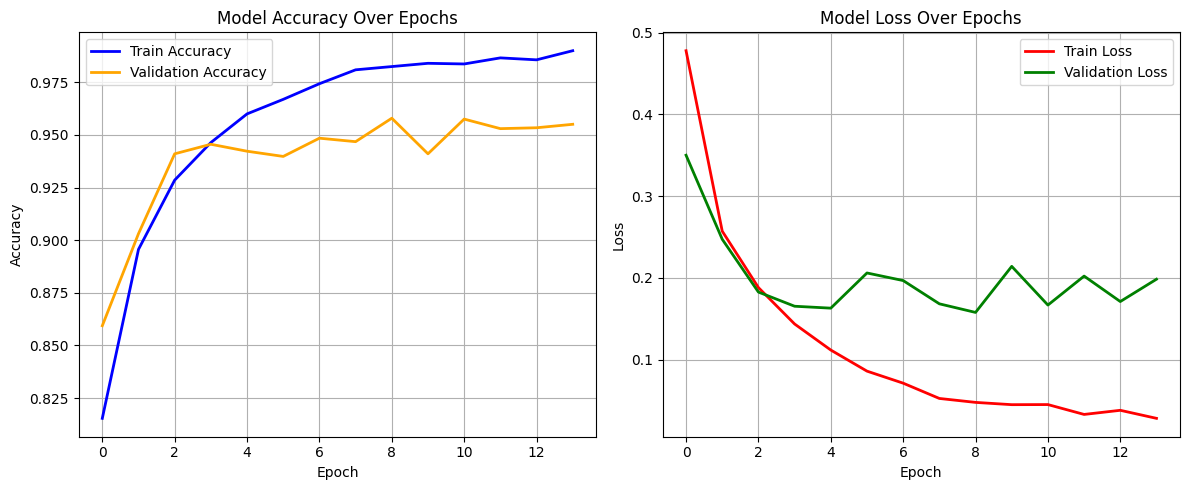

In [11]:
plt.figure(figsize=(12, 5))

# 🔹 Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# 🔹 Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red', linewidth=2)
plt.plot(history.history.get('val_loss', []), label='Validation Loss', color='green', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Confusion Matrix:
[[ 668   53    2]
 [  40 1976   23]
 [   3   10  256]]


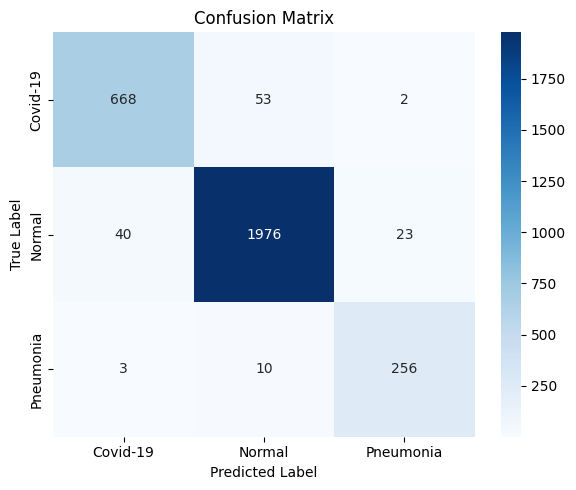


Classification Report:

              precision    recall  f1-score   support

    Covid-19       0.94      0.92      0.93       723
      Normal       0.97      0.97      0.97      2039
   Pneumonia       0.91      0.95      0.93       269

    accuracy                           0.96      3031
   macro avg       0.94      0.95      0.94      3031
weighted avg       0.96      0.96      0.96      3031



In [12]:
predictions = model.predict(testX)
y_pred = np.argmax(predictions, axis=1)  # Convert softmax output to class indices
y_true = np.argmax(testY, axis=1)        # Convert one-hot encoded labels to class indices

# 🧮 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Covid-19', 'Normal', 'Pneumonia']  # Must match label encoding order

# 🧾 Print Raw Confusion Matrix
print("Confusion Matrix:")
print(cm)

# 📊 Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 🗂️ Detailed Metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [13]:
model.save('CNN_Covid19_Xray_Version.h5') 


import pickle

pickle.dump(le, open("Label_encoder.pkl",'wb'))
print("saved")

saved


In [14]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('CNN_Covid19_Xray_Version.h5')

le = pickle.load(open("Label_encoder.pkl",'rb'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


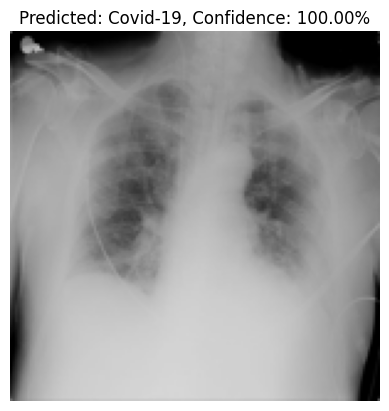

Predicted Label: Covid-19, Confidence Score: 100.00%


In [16]:


def detection_system(image_path, model, label_encoder, image_size=150):
    """
    Detection system function to classify an input image.

    Parameters:
    - image_path: The path to the image to classify.
    - model: The trained Keras model.
    - label_encoder: The LabelEncoder used to encode the labels.
    - image_size: The target size for resizing the image (default: 150x150).
    
    Returns:
    - predicted_label: The predicted class label.
    - confidence_score: The confidence score of the predicted class.
    """
    # Load the image from the provided path
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    
    # Convert image from BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image to the same size as the training images
    image_resized = cv2.resize(image_rgb, (image_size, image_size))
    
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_resized / 255.0
    
    # Expand the dimensions to match the input shape for the model
    image_input = np.expand_dims(image_normalized, axis=0)
    
    # Predict the class of the image
    predictions = model.predict(image_input)
    
    # Get the predicted class index and confidence score
    predicted_index = np.argmax(predictions)
    confidence_score = predictions[0][predicted_index]
    
    # Decode the predicted index back to the original label
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]
    
    
    # Display the image with the predicted label and confidence score
    plt.imshow(image_resized)
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score*100:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence_score

# Example usage
image_path = r"C:\Users\swarn\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5\COVID-19_Radiography_Dataset\COVID\images\COVID-1.png"
predicted_label, confidence_score = detection_system(image_path, model, le)
print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score*100:.2f}%")

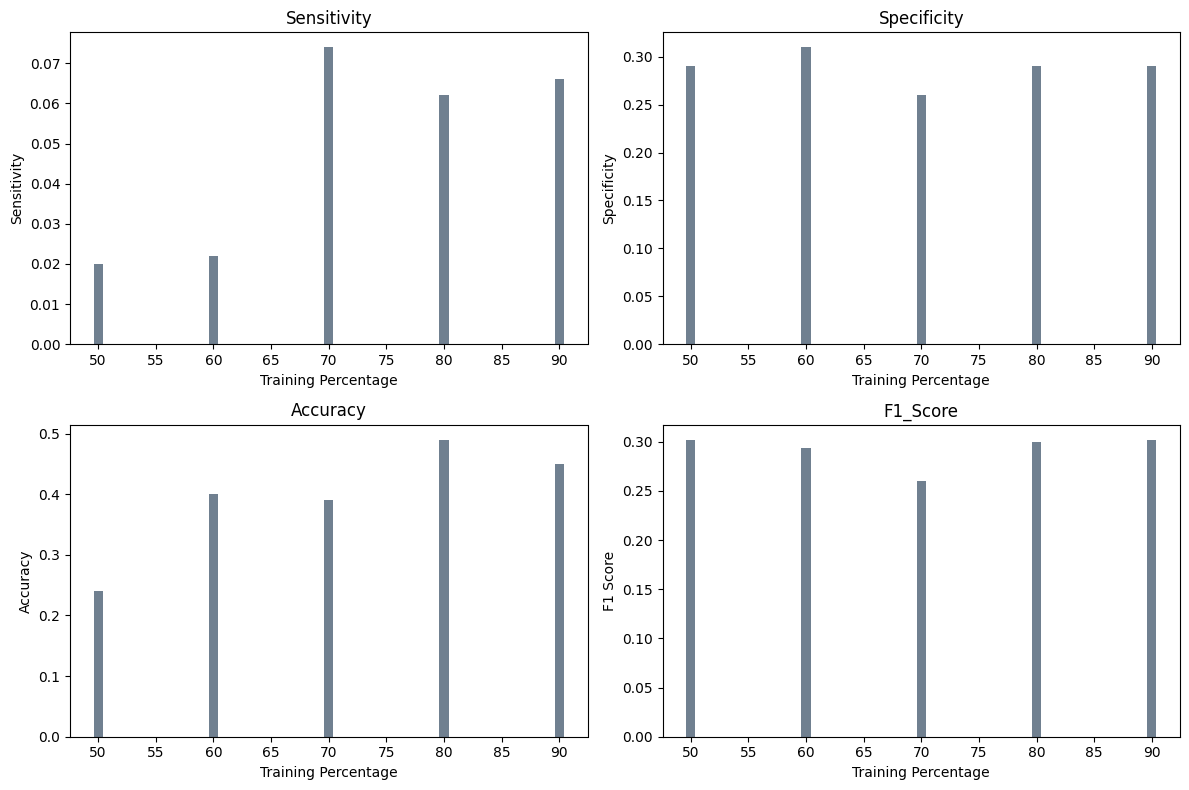

In [17]:


# Data
training_percentages = [50, 60, 70, 80, 90]
sensitivity = [0.02, 0.022, 0.074, 0.062, 0.066]
specificity = [0.29, 0.31, 0.26, 0.29, 0.29]
accuracy = [0.24, 0.40, 0.39, 0.49, 0.45]
f1_score = [0.302, 0.294, 0.26, 0.30, 0.302]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Sensitivity
axs[0, 0].bar(training_percentages, sensitivity, color='slategray')
axs[0, 0].set_title('Sensitivity')
axs[0, 0].set_xlabel('Training Percentage')
axs[0, 0].set_ylabel('Sensitivity')

# Specificity
axs[0, 1].bar(training_percentages, specificity, color='slategray')
axs[0, 1].set_title('Specificity')
axs[0, 1].set_xlabel('Training Percentage')
axs[0, 1].set_ylabel('Specificity')

# Accuracy
axs[1, 0].bar(training_percentages, accuracy, color='slategray')
axs[1, 0].set_title('Accuracy')
axs[1, 0].set_xlabel('Training Percentage')
axs[1, 0].set_ylabel('Accuracy')

# F1 Score
axs[1, 1].bar(training_percentages, f1_score, color='slategray')
axs[1, 1].set_title('F1_Score')
axs[1, 1].set_xlabel('Training Percentage')
axs[1, 1].set_ylabel('F1 Score')

plt.tight_layout()
plt.show()


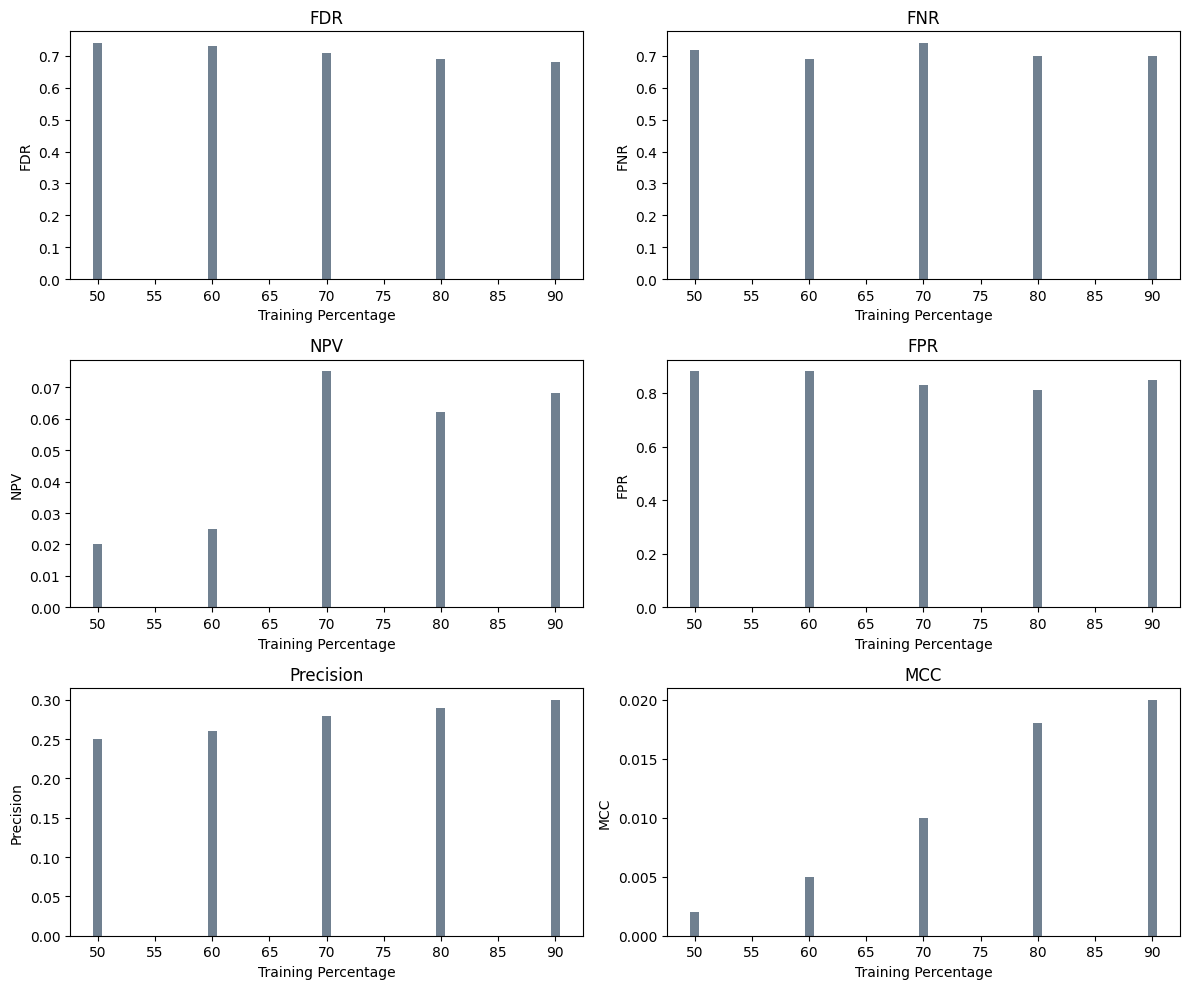

In [19]:


# Training percentages
training_percentages = [50, 60, 70, 80, 90]

# Metrics
fdr = [0.74, 0.73, 0.71, 0.69, 0.68]
fnr = [0.72, 0.69, 0.74, 0.70, 0.70]
npv = [0.02, 0.025, 0.075, 0.062, 0.068]
fpr = [0.88, 0.88, 0.83, 0.81, 0.85]
precision = [0.25, 0.26, 0.28, 0.29, 0.30]
mcc = [0.002, 0.005, 0.010, 0.018, 0.020]

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Plotting each metric
axs[0, 0].bar(training_percentages, fdr, color='slategray')
axs[0, 0].set_title("FDR")
axs[0, 0].set_xlabel("Training Percentage")
axs[0, 0].set_ylabel("FDR")

axs[0, 1].bar(training_percentages, fnr, color='slategray')
axs[0, 1].set_title("FNR")
axs[0, 1].set_xlabel("Training Percentage")
axs[0, 1].set_ylabel("FNR")

axs[1, 0].bar(training_percentages, npv, color='slategray')
axs[1, 0].set_title("NPV")
axs[1, 0].set_xlabel("Training Percentage")
axs[1, 0].set_ylabel("NPV")

axs[1, 1].bar(training_percentages, fpr, color='slategray')
axs[1, 1].set_title("FPR")
axs[1, 1].set_xlabel("Training Percentage")
axs[1, 1].set_ylabel("FPR")

axs[2, 0].bar(training_percentages, precision, color='slategray')
axs[2, 0].set_title("Precision")
axs[2, 0].set_xlabel("Training Percentage")
axs[2, 0].set_ylabel("Precision")

axs[2, 1].bar(training_percentages, mcc, color='slategray')
axs[2, 1].set_title("MCC")
axs[2, 1].set_xlabel("Training Percentage")
axs[2, 1].set_ylabel("MCC")

# Tidy layout
plt.tight_layout()
plt.show()
